In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize



In [3]:
# Custom dataset class
class CustomLogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for label, subdir in enumerate(['Fake', 'Genuine']):
            folder_path = os.path.join(self.root_dir, subdir)
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    self.images.append(os.path.join(folder_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])




In [4]:
# Load the trained EfficientNet model
def load_trained_model(model_path):
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1])
    return y_true, y_pred, y_scores

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [5]:
# # Main execution
# if __name__ == "__main__":
#     # Set device
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # Load the model
#     model_path = 'efficient_net_logo_detection_model.pth'
#     model = load_trained_model(model_path)
#     model = model.to(device)

#     # Prepare test dataset and dataloader
#     test_dataset = CustomLogoDataset('FakeReal Logo Detection dataset/test', transform=image_transforms)
#     test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#     # Evaluate the model
#     y_true, y_pred, y_scores = evaluate_model(model, test_dataloader, device)

#     # Print classification report
#     target_names = ['Fake', 'Genuine']
#     print(classification_report(y_true, y_pred, target_names=target_names))

#     # Plot precision-recall curve
#     plot_precision_recall_curve(y_true, y_scores)

#     # Plot ROC curve
#     plot_roc_curve(y_true, y_scores)


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

Loaded pretrained weights for efficientnet-b0
              precision    recall  f1-score   support

        Fake       0.92      1.00      0.96       110
     Genuine       1.00      0.84      0.91        55

    accuracy                           0.95       165
   macro avg       0.96      0.92      0.94       165
weighted avg       0.95      0.95      0.94       165



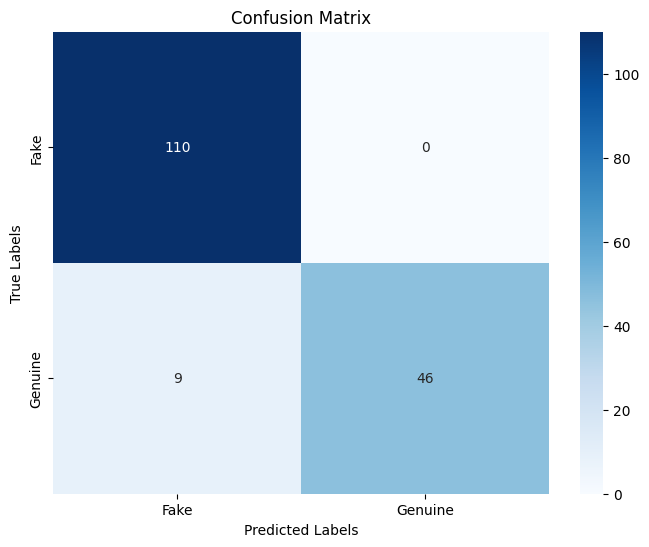

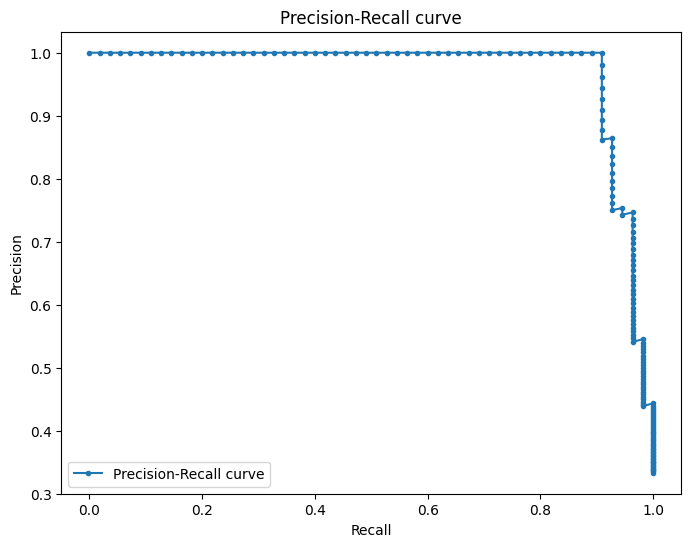

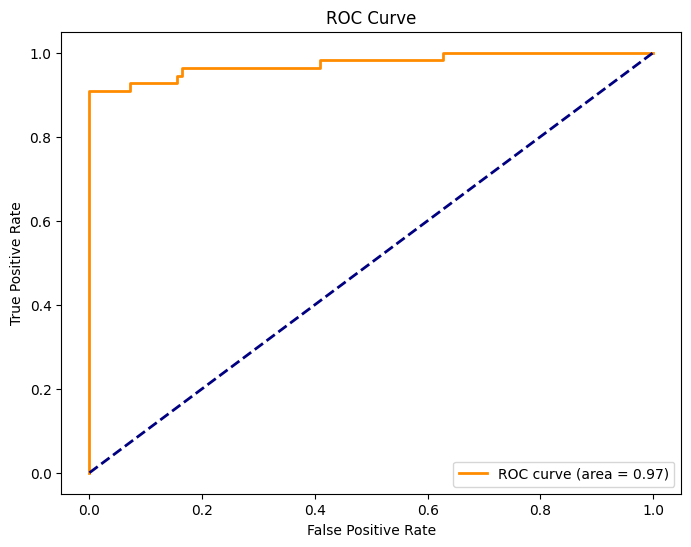

In [7]:


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Genuine'], yticklabels=['Fake', 'Genuine'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model
    model_path = 'efficient_net_logo_detection_model.pth'
    model = load_trained_model(model_path)
    model = model.to(device)

    # Prepare test dataset and dataloader
    test_dataset = CustomLogoDataset('FakeReal Logo Detection dataset/test', transform=image_transforms)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Evaluate the model
    y_true, y_pred, y_scores = evaluate_model(model, test_dataloader, device)

    # Print classification report
    target_names = ['Fake', 'Genuine']
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)

    # Plot precision-recall curve
    plot_precision_recall_curve(y_true, y_scores)

    # Plot ROC curve
    plot_roc_curve(y_true, y_scores)
